In [1]:
#import libraries
import sys 
sys.path.append("../../../1.2-HyperParameterTuning")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import StandardScaler

In [2]:
BASE_DATA_DIR="../../data2apply/"
data_dir=os.path.join(BASE_DATA_DIR,"pump_data")
train_dir=os.path.join(data_dir,"clean_data.csv")

In [3]:
#dataset de los datos 

class PumpData(object):
    def __init__(self,data_dir,stride=5,winsize=100,norm=True):


        self.window_size=winsize
        self.df=pd.read_csv(data_dir,index_col=0)
        self.stride=stride
        scaler=StandardScaler()
        
        self.sensores_data_array=self.df.iloc[:3000,1:-1].to_numpy()
        #self.length=3000#self.sensores_data_array.shape[0]

        if norm:
            self.sensores_data_array=scaler.fit_transform(self.sensores_data_array)
        
        self.sine_wave=torch.from_numpy(self.sensores_data_array) #esto es necesario porque luego lo usa otra clase
        self.length=self.sine_wave.shape[0]
        #y vamos a enventanar
        aux=[]
        for i in range(0,self.sensores_data_array.shape[0]-winsize,stride):
            aux.append(self.sensores_data_array[i:(i+winsize)])
        self.array=torch.tensor(np.array(aux))
        #self.sensores_data_tensor=torch.from_numpy(self.sensores_data_array)
        self.list_anomalies=[]
        aux=self.df.loc[self.df["machine_status"]!=0].iloc[:3000,-1].index.to_numpy()
        self.status_column=self.df["machine_status"].iloc[:3000].to_numpy() #las labels 
        group=[aux[0]]
        for i in range(aux.shape[0]-1):
            if aux[i+1]==(aux[i]+1):
                group.append(aux[i+1])
            else:
                self.list_anomalies.append(group)
                group=[aux[i+1]]
        self.list_anomalies.append(group)


        self.timestamp=self.df.iloc[:3000,1].to_numpy()


    def __len__(self):
        return self.array.shape[0]
    
    def __getitem__(self,index):
        return self.array[index]




In [4]:


class AnomalyModel:
    def __init__(self, AnomalyTransformer, dataset, batch_size=16,window_size=100,enc_in=1,enc_out=1, d_model=64, n_heads=2, e_layers=2, d_ff=32,
                 dropout=0.1, activation='relu',  lambda_=1e-3,max_norm=0.1,norm_type=2,sigma_a=5,sigma_b=3,clip_sigma="abs"):
        self.model = AnomalyTransformer(window_size, enc_in, enc_out, d_model, n_heads, e_layers, d_ff, dropout, activation,
                                        sigma_a=sigma_a,sigma_b=sigma_b,clip_sigma=clip_sigma, output_attention=True,)
        self.model.cuda()
        self.N=e_layers
        self.model = self.xavier_initialization(self.model)
        self.dataset=dataset
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lambda_ = lambda_
        self.max_norm=max_norm
        self.batch_size=batch_size
        self.norm_type=norm_type
        self.window_size=window_size
        self.sigma_a=sigma_a
        self.sigma_b=sigma_b
        self.clip_sigma=clip_sigma
    @staticmethod
    def xavier_initialization(model):
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        return model

    @staticmethod
    def my_kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def layer_association_discrepancy(Pl, Sl):
        B, Head, Height, _ = Pl.shape
        kl1 = AnomalyModel.my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
        kl2 = AnomalyModel.my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))
        ad_vector = kl1 + kl2
        return ad_vector

    @staticmethod
    def association_discrepancy(P_list, S_list):
        return torch.stack([AnomalyModel.layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

    @staticmethod
    def loss_function(x_hat, P_list, S_list, lambda_, x):
        frob_norm = (torch.linalg.norm(x_hat- x,dim=(1,2))**2).mean(axis=0) #((x_hat - x)**2).sum()
        #diss_norm = torch.mean(AnomalyModel.association_discrepancy(P_list, S_list))
        diss_norm = (torch.abs(AnomalyModel.association_discrepancy(P_list, S_list)).sum(dim=1)).mean()
        print(frob_norm, diss_norm)
        return (frob_norm.item(), diss_norm.item()), frob_norm - (lambda_ * diss_norm)

    @staticmethod
    def min_loss(output, P_layers, S_layers, x, lambda_):
        P_list = P_layers
        S_list = [S.detach() for S in S_layers]
        lambda_ = -lambda_
        _, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return loss_value

    @staticmethod
    def max_loss(output, P_layers, S_layers, x, lambda_):
        P_list = [P.detach() for P in P_layers]
        S_list = S_layers
        lambda_ = lambda_
        details, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return details, loss_value
    
    def cosine_lr_schedule_with_warmup(self, optimizer, epoch, initial_lr, total_epochs, warmup_epochs):
        if warmup_epochs!=0:
            if epoch < warmup_epochs:
                lr = initial_lr * (epoch + 1) / warmup_epochs
            else:
                adjusted_epoch = epoch - warmup_epochs
                adjusted_total_epochs = total_epochs - warmup_epochs
                lr = 0.5 * initial_lr * (1 + math.cos(math.pi * adjusted_epoch / adjusted_total_epochs))

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


    def clip_gradients(self):
        """
        Clip gradients of the model parameters.

        Args:
            model (torch.nn.Module): The neural network model.
            max_norm (float): The maximum allowed norm for the gradients.
            norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
        """
        # Recupera todos los gradientes de los parámetros del modelo
        gradients = [param.grad for param in self.model.parameters() if param.grad is not None]

        # Calcula la norma total de los gradientes
        total_norm = torch.norm(torch.stack([torch.norm(grad, self.norm_type) for grad in gradients]), self.norm_type)

        # Calcula el factor de escalado para recortar los gradientes
        clip_coef = self.max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            # Aplica el factor de escalado a los gradientes
            for grad in gradients:
                grad.mul_(clip_coef)



    def schedule_lambda(self,epoch,num_epochs,init_lambda,final_lambda):
        self.lambda_=(final_lambda-init_lambda)/num_epochs * epoch + init_lambda
        
    def train(self, num_epochs, initial_lr, warmup_epochs,init_lambda,final_lambda):
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)
        self.num_epochs=num_epochs
        self.initial_lr=initial_lr
        self.model.train()
        loss_frob_diss = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")
            self.schedule_lambda(epoch,num_epochs,init_lambda,final_lambda)
            for i, (inputs) in enumerate(self.dataloader):
                inputs = inputs.float().to("cuda:0")
                outputs, series, prior, _ = self.model(inputs)
                #esto ya lo hacemos dentro del calculo de la perdida
                #prior = [j / torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior]



                loss_min = self.min_loss(outputs, prior, series, inputs, self.lambda_)
                loss_min.backward(retain_graph=True)
                #optimizer.step()
                #optimizer.zero_grad()

                details, loss_max = self.max_loss(outputs, prior, series, inputs, self.lambda_)
                loss_max.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_frob_diss.append(list(details))

                #loss_max.backward(retain_graph=True)
                #loss_min.backward()
                if self.max_norm is not None:
                    self.clip_gradients()
                #optimizer.step()
                #optimizer.zero_grad()

                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.dataloader)}], Loss: {loss_max.item():.4f}")
            if warmup_epochs is not None:
                self.cosine_lr_schedule_with_warmup(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)

        print("Entrenamiento finalizado")
        self.loss = np.array(loss_frob_diss)
    
    def predict(self, data=None):
        if data is None:
            data = next(iter(self.dataloader)).float().to("cuda:0")
        else:
            data = torch.tensor(data).float()
            data = data.to("cuda:0") # .unsqueeze(0) -> esto si solo tiene un canal y no lo hemos puesto

        self.model.eval()
        with torch.no_grad():
            out, series, prior, sigmas = self.model(data)

        out = out.cpu().numpy()
        series = [s.cpu().numpy() for s in series]
        prior = [p.cpu().numpy() for p in prior]
        sigmas = [sigma.cpu().numpy() for sigma in sigmas]

        return data.cpu().detach().numpy(),out, series, prior, sigmas


    @staticmethod
    def anomaly_score(model, input=None, crit_batch_size=32):
        input = input.float().to("cuda:0")
        model.eval()
        num_batches = int(input.size(0) / crit_batch_size) + (1 if input.size(0) % crit_batch_size != 0 else 0)

        # Inicializa un tensÇor vacío para almacenar los resultados
        result = torch.empty(0, device="cuda:0")

        for i in range(num_batches):
            batch_start = i * crit_batch_size
            batch_end = min((i + 1) * crit_batch_size, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = model(input_batch)
            ad = F.softmax(
                -AnomalyModel.association_discrepancy(prior, series), dim=0
            )

            norm = ((out - input_batch) ** 2).sum(axis=-1)

            score = torch.mul(ad, norm)

            # Añade el resultado del lote actual al tensor de resultado
            result = torch.cat((result, score), dim=0)

        return result





In [5]:
#tenemos el modelo entrenado en una clase, y otra case el con tipo de datos.
#ahora necesitamos algo que nos encapsule la evaluacion de los resultados obtenidos
#para ello creamos la clase
class EvalModel(object):
    def __init__(self,model_instance,dataset_instance,hp,save_directory=None,batch_predict=16):
        self.model_instance=model_instance
        self.dataset=dataset_instance
        self.batch_predict=batch_predict
        self.save_directory=save_directory
        self.window_anomalies()

        #self.windowed_data2eval=self.windowed_data2eval#.unsqueeze(-1) #leañadimos una dimeninsion porque oslo tiene 1 variable 
        self.hp=hp #esto es una lista con los hiperparametros

        self.run_model()

        self.evaluate_model()


    def run_model(self):
        input = self.windowed_data2eval.float().to("cuda:0")
        self.model_instance.model.eval()
        num_batches = int(input.size(0) / self.batch_predict) + (1 if input.size(0) % self.batch_predict != 0 else 0)

        # Inicializa tensores vacíos para almacenar los resultados
        out_list =[]
        series_list =[]
        prior_list =[]
        sigmas_list =[]

        for i in range(num_batches):
            batch_start = i * self.batch_predict
            batch_end = min((i + 1) * self.batch_predict, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = self.model_instance.model(input_batch)
            [print(k.shape) for k in series]
            # Añade el resultado del lote actual a los tensores de resultado
            out_list.append( out)
            series_list.append( torch.stack(series).transpose(0,1))#esto que nos devuelve con listas, asi que los haremos tensores
            prior_list.append( torch.stack(prior).transpose(0,1))
            sigmas_list.append( torch.stack(sigmas).transpose(0,1))

        # Guarda los resultados en los atributos de la clase
        self.out_list = torch.cat(out_list,dim=0)
        self.series_list = torch.cat(series_list,dim=0)
        self.prior_list = torch.cat(prior_list,dim=0) #el output son bloques x muestras x cabezas x Len x Len 
        self.sigmas_list = torch.cat(sigmas_list,dim=0)

    def window_anomalies(self):
        #pero en lugar de darle un batch del dataLoader, vamos a darle las ventanas en las que encontramos anomalias
        aux=[]
        for i in self.dataset.list_anomalies:
            if (i[0]-self.dataset.window_size//2)>0:
                init_window=i[0]-self.dataset.window_size//2
            else:
                init_window=0

            if (init_window+self.dataset.window_size)>self.dataset.sine_wave.shape[0]:
                end_window=self.dataset.sine_wave.shape[0]
                init_window=self.dataset.sine_wave.shape[0]-self.dataset.window_size
            else:
                end_window=init_window+self.dataset.window_size
            if (end_window-init_window)==self.dataset.window_size:
                aux.append(self.dataset.sine_wave[init_window:end_window])
        self.windowed_data2eval=torch.stack(aux)

    def evaluate_model(self):
        #aqui generamos todos los plot y todo, y los guardamos en el directorio indicado -> save_directory

        self.anomaly_score=AnomalyModel.anomaly_score(self.model_instance.model, self.windowed_data2eval)
        aux=AnomalyModel.anomaly_score(self.model_instance.model, self.dataset.array)
        #me estoy haciendo la pixa un lio con todo esto
        # if ((aux.shape[0]*self.dataset.stride+self.dataset.window_size)==self.dataset.sensores_data_array.shape[0]):
        #     excedente=self.dataset.window_size-5
        # else:
        #     exedente=0
        
        #empt=torch.empty(aux.shape[0],aux.shape[0]*self.dataset.stride+excedente)
        empt=torch.empty(aux.shape[0],self.dataset.length)
        empt[:]=float("nan")
        for i,j in enumerate(aux):
            i_new=i*self.dataset.stride
            empt[i,i_new:(i_new+self.dataset.window_size)]=j
        self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))
        


    def generate_log_y_plots(self,canal=0):
        #esto es la ultima funcion encargada de todo el trabajo de guarda registros y tal
        self.canal_plot=canal

        if not os.path.exists(self.save_directory):
            os.mkdir(self.save_directory)

        #variadito

        #tanaño del axes final
        aux=self.out_list.shape[0]
        cols=3 if aux>=3 else aux
        rows=aux//cols
        if aux%cols!=0:
            rows+=1
        #calculamos las rows, que si la ultima no se termina, la añadimos, en plan... eso
        # y si es mayor que 5, lo dejamos en 5
        if rows>5:
            rows=5
        

        plt.figure(figsize=(cols*7,3*rows))
        for i in range(aux):
            plt.subplot(rows,cols,i+1)
            plt.plot(self.out_list[i,:,self.canal_plot].cpu().detach().numpy(),".-",label="out")
            plt.plot(self.windowed_data2eval[i,:,self.canal_plot].cpu().detach().numpy(),label="inp")
            plt.plot(self.anomaly_score[i,:].cpu().detach().numpy()[i]/self.anomaly_score.cpu().detach().numpy()[i,:].max(),label="AnomScore")
            plt.plot(self.sigmas_list[i,:,:,:,0].mean(dim=[0,1]).cpu().detach().numpy()/self.sigmas_list[i,:,:,:,0].mean(dim=[0,1]).cpu().detach().numpy().max(),label="sigma")
        plt.legend()
        plt.tight_layout()
        name_fig="rec_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()


#=======================0
        plt.figure(figsize=(12,6))
        plt.subplot(2,1,1)
        plt.plot(self.model_instance.loss[:,0])

        for i in range(self.model_instance.num_epochs-1):
            plt.axvline(i*(len(self.dataset)//self.model_instance.batch_size),color="red",alpha=0.2)

        plt.title("Reconstruction Loss",fontsize=15)
        plt.subplot(2,1,2)
        plt.plot(self.model_instance.loss[:,1])

        for i in range(self.model_instance.num_epochs-1):
            plt.axvline(i*(len(self.dataset)//self.model_instance.batch_size),color="red",alpha=0.2)

        plt.title("Association Discrepancy Loss",fontsize=15)
        plt.tight_layout()
        name_fig="loss_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#==============================000


        #tanaño del axes final
        rows=self.out_list.shape[0]

        if rows>5:
            rows=5
            
        plt.figure(figsize=(24,4*rows))
        for i in range(rows):
            aux_ts=self.windowed_data2eval[i,:,self.canal_plot].cpu().detach().numpy()
            aux_ts=(aux_ts-aux_ts.mean())/(aux_ts.std()*0.7)-8

            plt.subplot(rows,6,i*6+1)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,0].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+2)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,1].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+3)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,0,2].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+4)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,0].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+5)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,1].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+6)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.series_list[i,1,2].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
        plt.tight_layout()
        name_fig="series_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#===============

        #tanaño del axes final
        rows=self.out_list.shape[0]

        if rows>5:
            rows=5
        


        plt.figure(figsize=(24,rows*4))
        for i in range(rows):
            aux_ts=self.windowed_data2eval[i,:,self.canal_plot].cpu().detach().numpy()
            aux_ts=(aux_ts-aux_ts.mean())/(aux_ts.std()*0.7)-8

            plt.subplot(rows,6,i*6+1)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,0].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+2)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,1].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+3)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,0,2].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 1, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+4)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,0].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 1")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+5)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,1].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 2")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
            plt.subplot(rows,6,i*6+6)
            plt.xticks([])
            plt.yticks([])
            cax=plt.imshow(self.prior_list[i,1,2].cpu().detach().numpy())
            plt.plot(aux_ts,color="orange")
            plt.plot(aux_ts,np.arange(self.dataset.window_size),color="orange")
            plt.title("Block 2, Head 3")
            ax=plt.gca()
            divider = make_axes_locatable(ax)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)

            # Crea el colorbar ajustado al tamaño del axes
            plt.colorbar(cax, cax=cax2)
        plt.tight_layout()

        name_fig="prior_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()

#================

        plt.figure(figsize=(14,8))
        plt.plot(self.full_anomaly_score/self.full_anomaly_score.max(),"-r",label="Ass Dis")
        aux2=self.dataset.status_column[:self.full_anomaly_score.shape[0]]
        aux3=self.dataset.sensores_data_array[:self.full_anomaly_score.shape[0],self.canal_plot]
        plt.plot((aux2-aux2.min())/(aux2.max()-aux2.min()),alpha=0.6,label="anoms")
        plt.plot((aux3-aux3.min())/(aux3.max()-aux3.min()),alpha=0.6,label="señal")

        plt.tight_layout()

        name_fig="critScore_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        plt.close()
#=====================

        plt.figure(figsize=(14,5))

        plt.subplot(1,4,1)

        plt.hist(self.sigmas_list[:,:, :, :, 0].mean(dim=0).cpu().detach().numpy().flatten(),bins=120,alpha=0.5,histtype="stepfilled")
        plt.xlabel("sigma")
        plt.title("Media sobre todos los \n sigmas del batch",fontsize=13)

        plt.subplot(1,4,2)
        plt.hist(self.sigmas_list[:,0,:, :, 0].cpu().detach().numpy().flatten(),bins=100,alpha=0.4,histtype="stepfilled",label="Block 1")
        plt.hist(self.sigmas_list[:,1,:, :, 0].cpu().detach().numpy().flatten(),bins=100,alpha=0.4,histtype="stepfilled",label="Block 2")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo segundo bloque",fontsize=12)
        plt.subplot(1,4,3)
        plt.hist(self.sigmas_list[:,0,0, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 1")
        plt.hist(self.sigmas_list[:,0,1, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 2")
        plt.hist(self.sigmas_list[:,0,2, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 3")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo primer bloque, y primera cabeza",fontsize=12)

        plt.subplot(1,4,4)
        plt.hist(self.sigmas_list[:,1,0, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 1")
        plt.hist(self.sigmas_list[:,1,1, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 2")
        plt.hist(self.sigmas_list[:,1,2, :, 0].cpu().detach().numpy().flatten(),bins=80,alpha=0.3,histtype="stepfilled",label="Head 3")
        plt.xlabel("sigma")
        plt.legend()
        plt.title("Media sobre todos los sigmas del batch,\n solo segundo bloque, y primera cabeza",fontsize=12)
        plt.tight_layout()
        name_fig="sigmas_"+"_".join([ str(m) for m in self.hp])+".png"
        plt.savefig(os.path.join(self.save_directory,name_fig))
        
        plt.close("all")


        

Epoch: 0
tensor(8564.1074, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1017.9763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8564.1074, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1017.9763, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [1/37], Loss: 8563.0898
tensor(8154.0527, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1017.4453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8154.0527, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1017.4453, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [2/37], Loss: 8153.0352
tensor(8058.3784, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1023.6691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8058.3784, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1023.6691, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [3/37], Loss: 8057.3550
tensor(7310.8545, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1018.3696, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7310.8545, device=

/tmp/ipykernel_1172407/826540269.py:86: RuntimeWarning: Mean of empty slice
  self.full_anomaly_score=np.nan_to_num(np.nanmean(empt.cpu().detach().numpy(),axis=0))
/tmp/ipykernel_1172407/826540269.py:348: RuntimeWarning: invalid value encountered in divide
  plt.plot((aux2-aux2.min())/(aux2.max()-aux2.min()),alpha=0.6,label="anoms")


Epoch: 0
tensor(8568.1709, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.8895, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8568.1709, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.8895, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [1/37], Loss: 8567.2148
tensor(8056.1104, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.8547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8056.1104, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.8547, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [2/37], Loss: 8055.1543
tensor(8663.8887, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8663.8887, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.0970, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/2], Step [3/37], Loss: 8662.9336
tensor(8379.5498, device='cuda:0', grad_fn=<MeanBackward1>) tensor(955.4155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8379.5498, device='cuda:0

KeyboardInterrupt: 

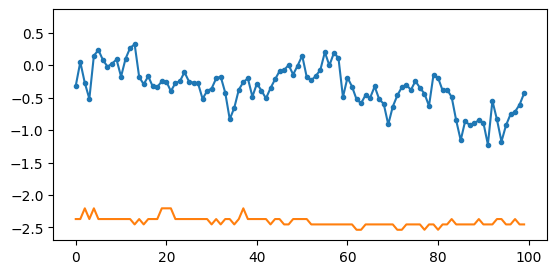

In [6]:
#el buble de entrenamiento seria algo asi
#vamos a empezar haciendo una grid search 
hyperparam_dict={"lambda":[0.001,0.01,0.1,3,10],"sigma_a":[1.2,2,3,4],"sigma_b":[1.1,2,5,10],"stop_epocas":[10,20,50,100,200,500],"clip_sigma":["yes","abs","no"]}

pumpdata=PumpData(train_dir)

# Parámetros de entrenamiento
num_epochs = 2
initial_lr = 0.0001
warmup_epochs = None


def check_hyperparams_in_log(log_file, hyperparams):
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if str(hyperparams) in line:
                    return True
        return False
    except:
        return False

def log_hyperparams(log_file, hyperparams):
    with open(log_file, 'a') as f:
        f.write(str(hyperparams) + '\n')

log_file = "../logs/logs.txt"

for lam in hyperparam_dict["lambda"]:
    for clip in hyperparam_dict["clip_sigma"]:

        if clip=="yes":
            for sigma_a in hyperparam_dict["sigma_a"]:
                for sigma_b in hyperparam_dict["sigma_b"]:
                    hyperparams = (lam, sigma_a, sigma_b, clip)
                    
                    if check_hyperparams_in_log(log_file, hyperparams):
                        continue
                    model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, pumpdata, n_heads=3, d_model=64, enc_in=40, enc_out=40, max_norm=None, sigma_a=sigma_a, sigma_b=sigma_b, clip_sigma=clip)
                    model_instance.train(num_epochs, initial_lr, warmup_epochs, lam, lam)
                    aux=EvalModel(model_instance,pumpdata,hyperparams,"../results")
                    aux.generate_log_y_plots()

                    log_hyperparams(log_file, hyperparams)  
        else:
            sigma_a="None"
            sigma_b="None"
            hyperparams = (lam, sigma_a, sigma_b, clip)
            
            if check_hyperparams_in_log(log_file, hyperparams):
                continue

            model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, pumpdata, n_heads=3, d_model=64, enc_in=1, enc_out=1, max_norm=None, sigma_a=sigma_a, sigma_b=sigma_b, clip_sigma=clip)
            model_instance.train(num_epochs, initial_lr, warmup_epochs, lam, lam)
            aux=EvalModel(model_instance,pumpdata,hyperparams,"../results2")
            aux.generate_log_y_plots()

            log_hyperparams(log_file, hyperparams) 
        del model_instance, aux
        torch.cuda.empty_cache()
        gc.collect()

        
